# Narrowband SETI: find hits (narrowband detections) in an h5 file
This notebook performs narrowband spectrum analysis on an h5 filterbank file.

For h5 mode, it does the following:

1) Inputs a single h5 spectrum file.  The fine FFT size and integration factor are already determined.
2) Runs TurboSETI, seticore or bliss and compiles a list of detections (in a .dat file) and measures compute time (wall clock)

This notebook may be called by another notebook to run multiple h5 files or to compare detection performance (detection SNR values)


#### Misc imports, system variables and functions

In [1]:
import sys
import os
import subprocess

import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline
params_large = {'legend.fontsize': 'medium',
                'figure.figsize': (10,6),
                'axes.labelsize': 'large',
                'axes.titlesize':'large',
                'xtick.labelsize':'large',
                'ytick.labelsize':'large'}
params_medium = {'legend.fontsize': 'medium',
                'figure.figsize': (10,6),
                'axes.labelsize': 'medium',
                'axes.titlesize':'medium',
                'xtick.labelsize':'medium',
                'ytick.labelsize':'medium'}
params_small = {'legend.fontsize': 'small',
                'figure.figsize': (10,6),
                'axes.labelsize': 'small',
                'axes.titlesize':'medium',
                'xtick.labelsize':'small',
                'ytick.labelsize':'small'}
plt.rcParams.update(params_large)
# mpl.rcParams['xtick.labelsize'] = 10

import src.plot_fns as pltg             # generic plot fns
import src.plot_h5_psd_sg1 as plt_h5    # blimpy-based plot fns

import math
import numpy as np
from astropy import units as u
import blimpy as bl
import time
import pandas
import h5py


from pathlib import Path

# sys.path.append(os.getenv('SETIGEN_PATH'))

# import setigen as stg

try:
    sg_dir
except NameError:
    sg_dir = os.getenv('SGDIR') + '/'
    
if not os.path.isdir(sg_dir[0:-1]):
    os.system('mkdir '+sg_dir[0:-1])

output_dir = os.getenv('OUTDIR') + '/'
if not os.path.isdir(output_dir[0:-1]):
    os.system('mkdir '+output_dir[0:-1])

def db(x):
    """ Convert linear value to dB value """
    return 10*np.log10(np.abs(x.astype(np.float64))+1e-20)

def find(cond,dim=0):
    """ Return indices according to conditon, e.g. find(x>2), like matlab find() """
    return np.nonzero(cond)[dim]

def in_interval(f,f12):
    """ Return True if f within f12 = [f1,f2] interval, e.g. in_interval(f,[f1,f2]) """
    f1 = f12[0]
    f2 = f12[1]
    if (f1<f2):
        return (f>=f1)&(f<=f2)
    else:
        return (f<=f1)&(f>=f2)
    
def wt_avg(snr_db,drift,sigma_drift):
    """ Probability-weighted SNR average according to drift rate """
    wt_avg1 = np.zeros(len(sigma_drift))
    sigma_drift1 = sigma_drift.astype(np.float64)
    for idx,sigma1 in enumerate(sigma_drift1):
        w = np.exp(-0.5*(drift.astype(np.float64)/sigma1)**2)
        wt_avg1[idx] = np.dot(snr_db,w)/np.sum(w)
    return wt_avg1

def file_name_mjd(input_file_stem):
    # specific to guppi file naming conventions
    stem_parts = input_file_stem.split('_')
    if (len(stem_parts)<4):
         mjd_int = 99999
    elif (stem_parts[1]=='guppi'):
        mjd_int = int(stem_parts[2])
    elif (stem_parts[2]=='guppi'):
        mjd_int = int(stem_parts[3])
    else:
        mjd_int = 99999
    #print(mjd_int)   
    return mjd_int

def get_branch(path_envvar):
    """Returns git branch name at $<path_envvar>"""
    branch_string = subprocess.check_output('git -C $'+path_envvar+' status -b -s', shell=True).decode("utf-8")
    parts1 = branch_string[3:-1].split('.')
    parts2 = parts1[0].split('\n')
    branch = parts2[0]
    return branch

def read_h5_setigen_data(file):
    """Returns chirp info embedded in h5 file"""
    drift_rate = []
    signal_width = []
    start_frequency = []
    snr_db = []
    n_chirp = 0
    try:
        with h5py.File(file, 'r') as f:
            try:
                X1 = f['setigen']
                drift_rate = X1['drift_rate'][()]
                signal_width = X1['signal_width'][()]
                start_frequency = X1['start_frequency'][()]
                snr_db = db(X1['zscore'][()])
                n_chirp = len(drift_rate)
            except Exception as e:
                print("No setigen data available")
        f.close()
    except Exception as e:
        exception_type = type(e).__name__
        exception_message = str(e)
        print(f"Error: {exception_type} {exception_message}")
    return n_chirp,start_frequency,drift_rate,snr_db,signal_width

def extract_det_table_cols(det_table):
    """Returns dict with columns of pandas DataFrame containing detection data from dat file """
    det = {'n_det': 0}
    if (len(det_table)>0):
        try:
            det_table = det_table.sort_values(by='Freq')
            det['f_center_MHz'] = det_table['Freq'].to_numpy()
            det['f_start_MHz'] = det_table['FreqStart'].to_numpy()
            det['f_end_MHz'] = det_table['FreqEnd'].to_numpy()
            det['drift_rate'] = det_table['DriftRate'].to_numpy()
            det['snr_db'] = db(det_table['SNR']).to_numpy()
            det['ChanIndx'] = det_table['ChanIndx'].to_numpy()
            det['n_det'] = len(det['f_center_MHz'])  
            det['f_delta_MHz'] = det['f_end_MHz'] - det['f_start_MHz']
            det['dc_freq_MHz'] = np.zeros(det['n_det'])
        except Exception as e:
            exception_type = type(e).__name__
            exception_message = str(e)
            print(f"Error: {exception_type} {exception_message}")
        
    if (det['n_det'] == 0):
        det['f_center_MHz'] = []
        det['f_start_MHz'] = []
        det['f_end_MHz'] = []
        det['drift_rate'] = []
        det['snr_db'] = []
        det['ChanIndx'] = []
        det['f_delta_MHz'] = []
        det['dc_freq_MHz'] = []
    return det

def select_det_cols(det_in,ii_select):
    """Inputs dict containing detection data, selects elements from index list ii_select """
    
    det_out = det_in.copy()

    if (det_in['n_det'] != 0):
        try:
            det_out['f_center_MHz'] = det_in['f_center_MHz'][ii_select]
            det_out['f_start_MHz'] = det_in['f_start_MHz'][ii_select]
            det_out['f_end_MHz'] = det_in['f_end_MHz'][ii_select]
            det_out['drift_rate'] = det_in['drift_rate'][ii_select]
            det_out['snr_db'] = det_in['snr_db'][ii_select]
            det_out['ChanIndx'] = det_in['ChanIndx'][ii_select]
            det_out['n_det'] = len(det_out['f_center_MHz'])  
            det_out['f_delta_MHz'] = det_in['f_delta_MHz'][ii_select]
            det_out['dc_freq_MHz'] = det_in['dc_freq_MHz'][ii_select]
        except Exception as e:
            exception_type = type(e).__name__
            exception_message = str(e)
            print(f"Error: {exception_type} {exception_message}")
    
    return det_out


In [2]:
try:
    parameters_are_undefined
except NameError:
    parameters_are_undefined = True     
    print('Parameters are undefined, using defaults\n')


Parameters are undefined, using defaults



In [3]:
# Sometimes it can be necessary to re-run this command for plots to show automatically
%matplotlib inline

#### Parameter setup for seticore, bliss or turboseti runs
Need to be sure proper seticore2 or bliss2 branch is set up and compiled (e.g. "git checkout sc2", "git status", "meson compile"), and indicated here

Note: test_case appears in plots and plot names, and can be set to the branch name or arbitrary string

In [4]:
if parameters_are_undefined:
    # app_to_run = 'turbo-10'         # turbo-<search_z_threshold ('snr')> 
    app_to_run = 'seticore-10'      # seticore-<search_z_threshold ('snr')>
    # app_to_run = 'seticore-20'      # seticore-<search_z_threshold ('snr')>
    # app_to_run = 'bliss-10-8'     # bliss-use for setigen h5 files - <search_z_threshold>-<pfb_order>
    # app_to_run = 'bliss-10-12'      # bliss- 12th order PFB (GBT)
    # app_to_run = 'bliss-10-16'      # bliss- 16th order PFB (GBT)
    # app_to_run = 'bliss-10-101'     # use special file 'GBT_spliced_PFB_response.f32'
    # app_to_run = 'bliss-10-8-8'     # bliss-use for setigen h5 files - <search_z_threshold>-<pfb_order>-<n_eq_ch>
    # app_to_run = 'Bliss_C+-4_dat-10'     # plot dat file for bliss runs 
    # app_to_run = 'Bliss_C0-11_dat-10'     # plot dat file for bliss runs 
    app_to_run = 'seticore-sc4-Box40-10_dat'      # seticore-<search_z_threshold ('snr')>
    min_abs_drift_Hz_sec = 0.01
    dc_blank = True
    

run_dat = app_to_run.lower().find('dat')>=0
run_turbo = app_to_run.lower().find('turbo')>=0
run_seticore = app_to_run.lower().find('seticore')>=0
run_bliss = app_to_run.lower().find('bliss')>=0
search_z_threshold = 10
if (not run_dat):
    app_parts = app_to_run.split('-')
    if len(app_parts)>=2:
        search_z_threshold = int(app_parts[1])

if run_dat:
    # plot dat file only, no dedoppler run, assumes h5 file is available to read header
    print("Running dat files")
    if (app_to_run.find('Bliss')>=0):
        search_app_name = 'Bliss'
        search_app_string = 'Bliss'
        dat_dir = '/mnt/d/data_files/seti_benchmarking/Bliss_dat_files/'
        dat_subdir = app_to_run.split('_dat')[0] + '/'
        test_case = ''
    elif (app_to_run.find('seticore')>=0):
        search_app_name = 'Seticore'
        search_app_string = 'Seticore'
        dat_dir = output_dir
        dat_subdir = ''
        test_case = app_to_run.split('_dat')[0].split('seticore-')[1]
    run_seticore = False
    run_bliss = False
    search_z_threshold = 0.
    branch = ''
elif run_turbo:
    search_app_name = 'turboSETI'
    search_app_string = 'turboSETI'
    run_seticore = False
    branch = ''
    test_case = search_app_string + f'-{search_z_threshold}'
elif run_bliss:
    search_app_name = 'bliss_find_hits2'
    search_app_string = 'Bliss2'
    run_seticore = False
    branch = get_branch('BL2')
    bliss_device_str = '"cuda:0"'
    # bliss_device_str = '"cpu"'
    if len(app_parts)>=3:
        pfb_order = int(app_parts[2])
    else:
        pfb_order = 12
    if len(app_parts)>=4:
        n_eq_ch = int(app_parts[3])
    else:
        n_eq_ch = 256
    # test_case = f'{branch}-{search_z_threshold}-{pfb_order}'
    test_case = f'{branch}-{search_z_threshold}-{pfb_order}-{n_eq_ch}'
    if (pfb_order==101):
        pfb_file = 'GBT_spliced_PFB_response.f32'
    else:
        pfb_file = f'chnl_1024K_{pfb_order}_{n_eq_ch}ch.f32'
    print(f'{bliss_device_str=}, {test_case=}, {pfb_file=}, {n_eq_ch=}')
else:
    search_app_name = 'seticore2'
    run_seticore = True
    branch = get_branch('SC2')
    test_case = branch
    if (branch=='sc4'):
        # test_case += f'-Base'
        test_case += f'-Box40'
    else:
        test_case += f'-Base'
    # test_case += f'{min_abs_drift_Hz_sec:.3f}'[1:]
    
    search_app_name = 'seticore2'
    if (branch.lower().find('sc0')>=0):
        search_app_string = 'Seticore'
    else:
        search_app_string = 'Seticore2'
    
    test_case += f'-{search_z_threshold}'

# if (dc_blank):
#     test_case += "-DCB"
    
print(f'{min_abs_drift_Hz_sec=}')
print(f'{search_app_name=}, {search_app_string=}, {branch=}, {test_case=}, {search_z_threshold=}')

do_profile = False
fb_ext = '.h5'

Running dat files
min_abs_drift_Hz_sec=0.01
search_app_name='Seticore', search_app_string='Seticore', branch='', test_case='sc4-Box40-10', search_z_threshold=0.0


In [5]:
if parameters_are_undefined:
    display_figs01 = True
    plot_all_dets = True
    verbose = True
    plot_sg_zoom = False
    plot_psd_zoom = False
    plot_multi_psd_zoom = False
    plot_sg_wb = False
    plot_psd_wb = False
    plot_channel_idx_dets = False
    plot_det_histogram = False

    plot_sg_psd_zoom = False
    max_n_BB_zoom_plots = 20
    max_n_NB_zoom_plots = 40
    max_n_multi_zoom_plots = 12
    zoom_NB_bw_MHz = .030   # +/- 15 KHz
    zoom_min_max_freq_MHz = []
    zoom_min_max_drift_rate = []
    beep_when_h5_complete = True

    if (1):
        search_max_drift = 10.0    # Hz/sec
        search_min_drift = -10.0   # ignored except for plotting
    else:
        search_max_drift = 5    # Hz/sec
        search_min_drift = -5   # ignored except for plotting
    
    base_h5_name = '' 
    bliss_dat_dir = '/mnt/d/data_files/seti_benchmarking/Bliss_dat_files/'
 
    fig_dir = 'plots/'

    if (1):
        base_h5_name = 'blc23_guppi_59046_80036_DIAG_VOYAGER-1_0011-1024K-Nsti-16.rawspec.0000.h5'
        # base_h5_name = 'blc43_guppi_59103_01984_DIAG_KEPLER-160_0010-1024K-Nsti-16.rawspec.0000.h5'
        base_h5_name = 'blc75_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.h5'
        # base_h5_name = 'blc1_guppi_57388_HIP113357_0010-1009K-Nsti-16.rawspec.0000.h5'
        # zoom_min_max_freq_MHz = [1620.,1630.]
        # base_h5_name = 'blc10_guppi_59239_37260_HIP50422_0024.rawspec.0000.h5'
        # base_h5_name = 'blc23_guppi_59189_51627_HIP50617_0025.rawspec.0000.h5'
        plot_multi_psd_zoom = True
        plot_det_histogram = True
    elif (0):
        sg_dir = '/mnt/d/data_files/seti_benchmarking/setigen/'
        # Ben Jacobsen-Bell test files with signals inserted with setigen
        # base_h5_name = 'uniform_spliced_blc4041424344454647_guppi_58885_63646_MESSIER081_0057.rawspec.0000.h5'
        # base_h5_name = 'uniform_blc73_guppi_58832_16209_MESSIER031_0057.rawspec.0000.h5'
        # base_h5_name = 'power_law_blc73_guppi_58832_16209_MESSIER031_0057.rawspec.0000.h5'
        # base_h5_name = 'power_law_spliced_blc4041424344454647_guppi_58885_63646_MESSIER081_0057.rawspec.0000.h5'
        # base_h5_name = 'widths_to_10_blc73_guppi_58832_16209_MESSIER031_0057.rawspec.0000.h5'
        # base_h5_name = 'ANDXIV_S_injections_unresolved_evenmorespace.h5'
        # base_h5_name = 'ANDXIV_S_injections_unresolved_samedrift_32kHz.h5'
    elif (0):
        # base_h5_name = 'blc71_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.h5'
        # base_h5_name = 'blc72_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.h5'
        base_h5_name = 'blc73_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.h5'
        # base_h5_name = 'blc74_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.h5'
        # base_h5_name = 'blc75_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.h5'
        # base_h5_name = 'blc76_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.h5'
        #
        # base_h5_name = 'blc73_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.h5'
        # base_h5_name = 'blc75_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.h5'
        # base_h5_name = 'uniform_blc73_guppi_58832_16209_MESSIER031_0057.rawspec.0000.h5'
        plot_sg_psd_zoom = True
        # zoom_min_max_freq_MHz = [1675.,1685.]
        # zoom_min_max_freq_MHz = [1623.,1630.]
        # zoom_min_max_freq_MHz = [1570.,1580.]     # gps
        # zoom_min_max_freq_MHz = [1560.,1570.]
        # zoom_min_max_freq_MHz = [1550.,1560.]
        # zoom_min_max_freq_MHz = [1540.,1550.]
        # zoom_min_max_freq_MHz = [1605.,1610.]
    elif (0):
        # base_h5_name = 'gbt-chirp80-0.0020V-6002.20-6003.80-m10.0-10.0-Hzsec-45.81sec-1024K-Nsti-16.rawspec.0000.h5'
        base_h5_name = 'gbt-chirp80-0.0020V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec-1024K-Nsti-16.rawspec.0000.h5'
        # base_h5_name = 'gbt-chirp80-0.0020V-6002.20-6003.80-m10.0-10.0-Hzsec-45.81sec-1024K-Nsti-04.rawspec.0000.h5'
        # base_h5_name = 'gbt-chirp80-0.0020V-6002.20-6003.80-m10.0-10.0-Hzsec-366.50sec-1024K-Nsti-04.rawspec.0000.h5'
        zoom_NB_bw_MHz = .012  # +/- 6 KHz
    elif (1):
        base_h5_name = 'blc00_guppi_59239_37260_HIP50422_0024.rawspec.0000.h5'
        # zoom_min_max_freq_MHz = [8330.,8340.]
        base_h5_name = 'blc20_guppi_59239_37260_HIP50422_0024.rawspec.0000.h5'
        # # zoom_min_max_freq_MHz = [6180.,6189.]
        plot_sg_psd_zoom = False
        # sg_dir = '/mnt/d/data_files/seti_benchmarking/HIP_TIC_59239/'
        # base_h5_name = 'blc30_guppi_59239_37260_HIP50422_0024.rawspec.0000.h5'
        # base_h5_name = 'blc31_guppi_59239_37260_HIP50422_0024.rawspec.0000.h5'
        # base_h5_name = 'blc32_guppi_59239_37260_HIP50422_0024.rawspec.0000.h5'
        # base_h5_name = 'blc33_guppi_59239_37260_HIP50422_0024.rawspec.0000.h5'
        # base_h5_name = 'blc34_guppi_59239_37260_HIP50422_0024.rawspec.0000.h5'
        # base_h5_name = 'blc35_guppi_59239_37260_HIP50422_0024.rawspec.0000.h5'
        # base_h5_name = 'blc36_guppi_59239_37260_HIP50422_0024.rawspec.0000.h5'
        # base_h5_name = 'blc37_guppi_59239_37260_HIP50422_0024.rawspec.0000.h5'
    elif (0):
        # unable to infer coarse channel size for data with dimensions: 40 x 2000000. please set the nfpc header.
        sg_dir = '/mnt/d/data_files/seti_benchmarking/navstar/'
        base_h5_name = 'diced_guppi_58968_53449_6058394809_GC_359.79-0.05_0001.0000.h5'
    elif (0):
        sg_dir = '/mnt/d/data_files/seti_benchmarking/mlc/'
        base_h5_name = 'spliced_blc0001020304050607_guppi_57541_59531_HIP13402_0014.gpuspec.0000.h5'
        plot_sg_psd_zoom = True
        zoom_min_max_freq_MHz = [1780.,1800.]
    elif (1):
        sg_dir = '/mnt/d/data_files/seti_benchmarking/Sample_Datasets_ASP/Catalogued_Signals/'
        # base_h5_name = 'fil_60654_19507_53782409_radec5.152,22.921_0001-beam0000.fbh5'
        # base_h5_name = 'fil_60654_19507_53782409_radec5.152-22.921_0001-beam0000.h5'
        base_h5_name = 'fil_60654_20973_53871887_radec5.153-22.922_0001-beam0000.h5'
        plot_sg_psd_zoom = True
    elif (0):
        sg_dir = '/mnt/d/data_files/seti_benchmarking/Sample_Datasets_ASP/Horseshoe_Artifact/'
        base_h5_name = 'fil_60689_09259_237727233_radec7.713-21.337_0001-beam0000.h5'
    elif (0):
        base_h5_name = 'blc23_guppi_59046_80036_DIAG_VOYAGER-1_0011-1024K-Nsti-16.rawspec.0000.h5'
        # base_h5_name = 'blc23_guppi_59046_80036_DIAG_VOYAGER-1_0011-1024K-Nsti-04.rawspec.0000.h5'
    elif (1):
        plot_sg_psd_zoom = True
        sg_dir = '/mnt/d/data_files/seti_benchmarking/KEPLER-160/'
        base_h5_name = 'blc47_guppi_59103_01984_DIAG_KEPLER-160_0010-1024K-Nsti-16.rawspec.0000.h5'


isVoyager = base_h5_name.lower().find('voyager')>=0
isguppi = base_h5_name.lower().find('guppi')>=0

drift_limit_nHz = 1.0  # assume 2 sigma limit
f_sigma_drift = np.array([1.5, 3, 6])*1e9
sigma_drift = drift_limit_nHz*f_sigma_drift/2.*1e-9
print(f'base_h5_name = {base_h5_name}')
    
t_e2e_start = time.time()


base_h5_name = blc75_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.h5


#### h5 mode initialization

In [6]:
full_base_h5_name = sg_dir + base_h5_name
# wf = bl.Waterfall(full_base_h5_name)

import src.get_h5_info as h5info
p = h5info.get_h5_params(full_base_h5_name)

h5_size_MB =p['h5_size_MB']
fig_f_limits_MHz = [p['f_min_MHz'],p['f_max_MHz']]

fine_fft_size = p['fine_fft_size']
n_lti = p['n_lti']
n_sti = p['n_sti']
n_avg = p['n_avg']
f_min_MHz = p['f_min_MHz']
f_max_MHz = p['f_max_MHz']
t_obs = p['t_obs']

telescope = p['telescop']
h5_size_MB = p['h5_size_MB']
n_coarse_channels = p['n_coarse_channels']

sig_min_drift = search_min_drift
sig_max_drift = search_max_drift

# open directory for figures if necessary
if not os.path.isdir(fig_dir[0:-1]):
    os.system('mkdir '+fig_dir[0:-1])

if (plot_sg_psd_zoom | plot_psd_zoom | plot_sg_zoom| plot_multi_psd_zoom):
    zoom_dir = fig_dir+test_case+'/'
    os.system('mkdir '+zoom_dir[0:-1])
    
# empty old figures
config_str = 'Nfft=%.0fK, Nsti=%d, Nlti=%.0f, %.1f sec  %s'%(fine_fft_size/1024,n_sti,n_lti,t_obs,test_case)
config_str2 = 'FineFFT-%.0fK-Nsti-%02d'%(fine_fft_size/1024,n_sti)
if verbose:print(config_str,'\n',config_str2)

input_file_stem = base_h5_name.split('.h5')[0]
fig_name_base =  input_file_stem

print(f'{fig_name_base = }')

f_start1_MHz = p['ctr_freq_MHz'] - 2*p['fs_coarse']*1e-6
f_stop1_MHz = p['ctr_freq_MHz'] + 2*p['fs_coarse']*1e-6
fig_f_limits_MHz = [f_start1_MHz,f_stop1_MHz]


blimpy.io.base_reader WARNING  Selection size is 4.00 GB, which exceeds the memory usage limit of 2.7368927001953125 GB. Keeping data on disk.
base_h5_name = '/home/kmh4005/data_files/sg_det_files/blc75_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.h5'
h5 file found
h5 File size =   3115 MB, n_h5_files = 1

GBT, 2019-12-15T04:30:09.000, mjd_day=58832, MESSIER031, ra_deg = 10.685, dec_deg = 41.268
ctr_freq_MHz = 1220.215, obs_bw_MHz = -187.5, chan_bw = -2929687.500, f_min_MHz = 1126.465, f_max_MHz = 1313.965

t_obs = 292.058, n_coarse_channels = 64, n_bits = 32, chan_bw = -2929687.500
fs_coarse = 2929687.500, fine_fft_size = 1048576, n_sti = 51, n_lti = 16, n_avg = 816
t_coarse = 3.413e-07, t_fine = 0.358, t_res = 18.254
fs_coarse = 2929687.500, fs_fine = 2.794
Nfft=1024K, Nsti=51, Nlti=16, 292.1 sec  sc4-Box40-10 
 FineFFT-1024K-Nsti-51
fig_name_base = 'blc75_guppi_58832_16209_MESSIER031_0057.gpuspec.0000'


mkdir: cannot create directory ‘plots/sc4-Box40-10’: File exists


#### Plot wideband spectra as required prior to search:

In [7]:
import src.plot_h5_psd_sg1 as plt_h5

if plot_sg_wb & (h5_size_MB<3500.0):

    %matplotlib inline
    try:
        plt_h5.plot_h5_sg(full_base_h5_name,
                fig_f_limits_MHz=fig_f_limits_MHz,
                min_max_db=[],
                fig_title=input_file_stem  + ' ' + config_str,
                display_fig=display_figs01,
                savfig_name=fig_dir+'01-'+fig_name_base+'-sg-'+test_case+'.png')
    except:
        print('Error encountered in 01 sg plot, skip')

if plot_psd_wb  & (h5_size_MB<3500.0):

    %matplotlib inline
    try: 
        plt_h5.plot_h5_psd_db(full_base_h5_name,
                fig_f_limits_MHz=fig_f_limits_MHz,
                min_max_db=[],
                rel_freq = False,
                fig_title=config_str,
                fig_text_list=[[.15,.85,input_file_stem]],
                display_fig=display_figs01,
                savfig_name=fig_dir+'02-'+fig_name_base+'-psd-'+test_case+'.png')
    except:
        print('Error encountered in 02 sg plot, skip')



#### Run turbo_seti if required

In [8]:
if run_turbo:
    
    base_dat_name = base_h5_name.split('.h5')[0] + '.dat'
    
    full_dat_name = output_dir + base_dat_name

    from turbo_seti.find_doppler.find_doppler import FindDoppler

    # Get rid of any pre-existing output files from a prior run.
    # for x_file in sorted(os.listdir(output_dir)):
    #     x_type = x_file.split('.')[-1]
    #     if x_type != 'h5':
    #         os.remove(output_dir + x_file)

    # Get ready for search by instantiating the doppler object.
    doppler = FindDoppler(full_base_h5_name,
                        max_drift = search_max_drift,
                        min_drift = min_abs_drift_Hz_sec,
                        snr = search_z_threshold,       
                        out_dir = output_dir # This is where the turboSETI output files will be stored.
                        )

    t1 = time.time()
    doppler.search()
    t_search0 = time.time() - t1
    t_search = t_search0/n_coarse_channels
    print(f'\TurboSeti Search complete {t_search0:.2f} sec {t_search:.2f} sec/coarse channel')

    print(full_dat_name)
    from turbo_seti.find_event.find_event import read_dat
    det_table = read_dat(full_dat_name)
    

#### Run seticore to detect drifting tones and note execution time

In [9]:
if run_seticore:
    
    base_dat_name = base_h5_name.split('.h5')[0] + '.' + test_case + '.dat'
    
    full_dat_name = output_dir + base_dat_name

    if (1):
        # process to include hits with zero drift, can be exclueded later
        seticore_str = search_app_name + ' ' + full_base_h5_name + \
            ' --max_drift='+ str(search_max_drift) + ' --min_drift=' + str(0.0) + \
            ' --snr=' + str(search_z_threshold) + '  --output=' + full_dat_name
    else:
        seticore_str = search_app_name + ' ' + full_base_h5_name + \
            ' --max_drift='+ str(search_max_drift) + ' --min_drift=' + str(min_abs_drift_Hz_sec) + \
            ' --snr=' + str(search_z_threshold) + '  --output=' + full_dat_name
    
    #    | tee data/output.txt
    if verbose: print(seticore_str)

    t1 = time.time()
    if do_profile:
        os.system('nsys profile ' + seticore_str + ' > seticore_text.out')
    else:
        # os.system(seticore_str)
        os.system(seticore_str+ ' > seticore_text.out')

    t_search0 = time.time() - t1
    t_search = t_search0/p['n_coarse_channels']
    print(f'\nSeticore search: {t_search0:.2f} sec {t_search:.2f} sec/coarse channel')
    
    # from turbo_seti.find_event.find_event import read_dat
    from src.find_event import read_dat
    det_table = read_dat(full_dat_name)


#### Run bliss to detect drifting tones and note execution time

In [10]:
if run_bliss:
    det_table = []

    base_dat_name = base_h5_name.split('.h5')[0] + '.' + test_case + '.dat'
    
    full_dat_name = output_dir + base_dat_name

    bliss_str = search_app_name + ' ' + full_base_h5_name + \
        ' -c 0 --number-coarse ' + str(p['n_coarse_channels']) + \
        ' --nchan-per-coarse ' + str(fine_fft_size) + \
        ' --excise-dc' + ' --device ' + bliss_device_str + ' ' + \
        ' --equalizer-channel ' + '$BL2/' + pfb_file +  \
        ' --min-drift ' + str(search_min_drift) + ' --max-drift '+ str(search_max_drift) + \
        ' --snr ' + str(search_z_threshold) + '  --output ' + full_dat_name
                
    #    | tee data/output.txt
    if verbose: print(bliss_str)

    t1 = time.time()
    if do_profile:
        os.system('nsys profile ' + bliss_str + ' > bliss_text.out')
    else:
        # os.system(bliss_str)
        os.system(bliss_str+ ' > bliss_text.out')

    t_search0 = time.time() - t1
    t_search = t_search0/p['n_coarse_channels']
    print(f'\nBliss search: {t_search0:.2f} sec {t_search:.2f} sec/coarse channel')
    
    from src.find_event import read_dat
    try:
        det_table = read_dat(full_dat_name)
    except:
        print('Bliss error: probably out of memory')
        assert(False)

#### For Bliss, optionally plot equalization function and equalized spectrum

In [11]:
if run_bliss and True:
    freqs_MHz, spectrum_db = plt_h5.plot_h5_psd_db(full_base_h5_name,
            fig_f_limits_MHz=fig_f_limits_MHz,
            min_max_db=[],
            rel_freq = False,
            do_plot = False)
    # Read in file
    eq_file_name = os.getenv('BL2') + '/' + pfb_file
    try:
        with open(eq_file_name, 'rb') as f:
            eq_db = db(np.fromfile(f, dtype=np.float32))
            print(f'File {eq_file_name} read complete')

            if (len(eq_db) != fine_fft_size):
                print(f'Error in eq filter length {len(eq_db)} vs {fine_fft_size}')

            eq_freq_MHz =  np.linspace(-p['fs_coarse']/2.*1e-6,p['fs_coarse']/2.*1e-6,fine_fft_size,endpoint=False)

            # interpolate equalization onto spectrum
            f_offset_from_local_ctr = np.mod((freqs_MHz*1e6 - p['fch1'] + p['chan_bw']/2.),p['chan_bw']) - p['chan_bw']/2. 

            eq_spectrum_db = spectrum_db - np.interp(f_offset_from_local_ctr*1e-6,eq_freq_MHz,eq_db)

            fig = plt.figure(figsize=(10, 6))

            plt.subplot(2,1,1)
            pltg.plot_generic(x_data=[freqs_MHz,freqs_MHz],y_data=[spectrum_db,eq_spectrum_db],
            # pltg.plot_generic(x_data=[freqs_MHz],y_data=[f_offset_from_local_ctr*1e-6],
                fig = fig,
                x_label = 'Frequency MHz',
                y_label = 'dB',
                fig_title= 'Spectrum After Equalization: ' + config_str,
                fig_text_list=[[.15,.85,base_h5_name]])
            
            plt.subplot(3,1,3)
            pltg.plot_generic(x_data=eq_freq_MHz,y_data=eq_db,
                fig = fig,
                y_limits=[-8.,2.],
                x_label = 'Frequency MHz from Coarse Channel Center',
                y_label = 'dB',
                fig_title = 'Bliss Channel Equalization Filter: ' + pfb_file)
            plt.savefig(fig_dir+'02a-'+fig_name_base+'-psd-'+test_case+'.png',bbox_inches='tight')
            if display_figs01:
                plt.show()
            else:
                plt.close(fig)
    except FileNotFoundError:
        # Bliss will crash if it can't find the file
        print(f"Error: File not found at {eq_file_name}")



#### dat mode: read in dat file associated with indicated h5 file

In [13]:
if run_dat:
    
    if (len(test_case)>0):
        base_dat_name = base_h5_name.split('.h5')[0] + '.' + test_case + '.dat'
    else:
        base_dat_name = base_h5_name.split('.h5')[0] + '.dat'
    
    full_dat_name = dat_dir + dat_subdir + base_dat_name

    if (not os.path.isfile(full_dat_name)):
        raise Exception(f"Error: dat file not found: {full_dat_name}")

    t_search = 0.

    # from turbo_seti.find_event.find_event import read_dat
    from src.find_event import read_dat

    try:
        det_table = read_dat(full_dat_name)
    except Exception as e:
        exception_type = type(e).__name__
        exception_message = str(e)
        print(f"Error: {exception_type} {exception_message}") 


In [14]:
base_dat_name

'blc75_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.sc4-Box40-10.dat'

#### Process detections from det_table

In [15]:
if (not det_table.empty):
    det_table = det_table.sort_values(by='Freq')

In [16]:
# det_table

#### Extract detection information into dictionary

In [17]:
det = extract_det_table_cols(det_table)
n_det = det['n_det']

# find DC frequency for coarse channel

for i_det in range(n_det):
    det['dc_freq_MHz'][i_det] = det['f_start_MHz'][i_det] + p['foff']*(p['fine_fft_size']/2. - det['ChanIndx'][i_det])


#### Separate Narrowband and Broadband Detections, including NB hits with drifts above threshold

In [18]:
if (n_det>0):
    ii_BB = find((det['drift_rate']==0.) & (det['f_delta_MHz']>.01))
else:
    ii_BB = []

BB_det = select_det_cols(det,ii_BB)
n_BB_det = BB_det['n_det']

# find DC frequency for coarse channel (corrected)

for i_det in range(n_BB_det):
    if (p['foff']>0):
        BB_det['dc_freq_MHz'][i_det] = BB_det['f_start_MHz'][i_det] + p['foff']*(p['fine_fft_size']/2. - BB_det['ChanIndx'][i_det])
    else:
        BB_det['dc_freq_MHz'][i_det] = BB_det['f_end_MHz'][i_det] - abs(p['foff'])*(p['fine_fft_size']/2. - BB_det['ChanIndx'][i_det])


if (n_det>0):
    # all NB dets including zero Hz/sec
    ii_NB0 = find(det['f_delta_MHz']<=.01)
    # all NB dets with |drift| >= min_abs_drift_Hz_sec
    ii_NB= find((abs(det['drift_rate'])>=min_abs_drift_Hz_sec) &(det['f_delta_MHz']<=.01))
else:
    ii_NB0 = []
    ii_NB = []

NB_det0 = select_det_cols(det,ii_NB0)
NB_det  = select_det_cols(det,ii_NB)

n_NB_det0 = NB_det0['n_det']
n_NB_det  = NB_det['n_det']


#### Histogram of detections vs drift rate

In [33]:
np.ceil(max(abs(NB_det0["drift_rate"])))

1.0

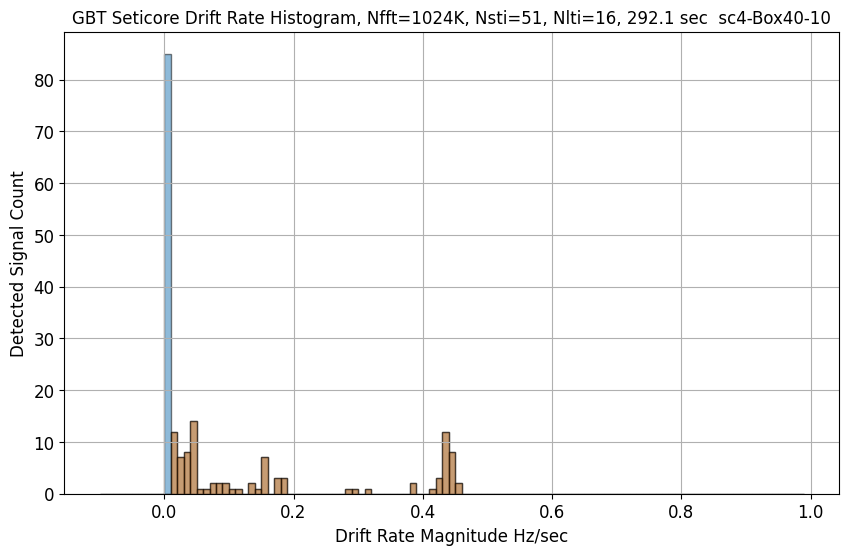

In [35]:
if (plot_det_histogram):
    # list of bins
    # bins = np.arange(search_min_drift-1,search_max_drift+1,.1)
    bins = np.arange(-.1,np.ceil(max(abs(NB_det0["drift_rate"]))),.01)

    # plotting labelled histogram
    %matplotlib inline
    fig = plt.figure(figsize=(10, 6))
    # plt.hist(NB_det0["drift_rate"], bins=bins, alpha =.5, edgecolor='black')
    # plt.hist(NB_det["drift_rate"], bins=bins, alpha =.5, edgecolor='black')
    plt.hist(abs(NB_det0["drift_rate"]), bins=bins, alpha =.5, edgecolor='black')
    plt.hist(abs(NB_det["drift_rate"]), bins=bins, alpha =.5, edgecolor='black')
    plt.grid()
    # plt.xlabel('Drift Rate Hz/sec')
    plt.xlabel('Drift Rate Magnitude Hz/sec')
    plt.ylabel('Detected Signal Count')
    plt.title(telescope.upper() + ' '+search_app_string+' Drift Rate Histogram, ' + config_str)
    savfig_name=fig_dir+'11-'+fig_name_base+'-hist-'+test_case+'.png'
    plt.savefig(savfig_name,bbox_inches='tight')
    plt.show()
    plt.close(fig)

#### Determine if NB detections are in BB range or not

In [20]:
NB_det_in_BB = [False]*n_NB_det

if (n_NB_det>0):
    for i_det in range(n_BB_det):
        NB_det_in_BB1 = np.logical_or( (NB_det['f_start_MHz'] >= BB_det['f_start_MHz'][i_det]) & (NB_det['f_start_MHz'] <= BB_det['f_end_MHz'][i_det]),
                                    (NB_det['f_end_MHz'] >= BB_det['f_start_MHz'][i_det]) & (NB_det['f_end_MHz'] <= BB_det['f_end_MHz'][i_det]) )
        
        NB_det_in_BB = NB_det_in_BB | NB_det_in_BB1

NB_det_outside_BB = np.logical_not(NB_det_in_BB)  

NB_det_out = select_det_cols(NB_det,NB_det_outside_BB)
n_NB_det_out = NB_det_out['n_det']

NB_det_in = select_det_cols(NB_det,NB_det_in_BB)
n_NB_det_in = NB_det_in['n_det']


#### Create composite plot line showing BB ranges

In [21]:
nf_dash = n_coarse_channels*128*8 + 1
f_dash = np.linspace(f_min_MHz,f_max_MHz,nf_dash)
df_dash = f_dash[1] - f_dash[0]
print(f'{df_dash = :.6f} MHz')
BB_dash = np.full(nf_dash, 0.)
idx_end = np.nan

for i_det in range(n_BB_det):
    idx_start = round((BB_det['f_start_MHz'][i_det]-f_min_MHz)/df_dash)
    idx_gap = idx_start - idx_end
    idx_end   = round((BB_det['f_end_MHz'][i_det]-f_min_MHz)/df_dash)
    idx_delta = idx_end - idx_start
    # print(f'{i_det} {idx_start=} {idx_end=} {idx_delta=} {idx_gap=}')
    BB_dash[idx_start:idx_end] = BB_det['snr_db'][i_det]

df_dash = 0.002861 MHz


In [22]:
BB_det_string_list = []
for i_det in range(n_BB_det):
    det_string1 = f'BB Det {i_det+1}: {BB_det["f_start_MHz"][i_det]:9.3f} - ' +\
            f'{BB_det["f_end_MHz"][i_det]:9.3f} MHz, Peak SNR {BB_det["snr_db"][i_det]:5.2f} dB, '
    BB_det_string_list.append(det_string1)
    
NB_det_string_list = []
for i_det in range(n_NB_det):
    total_drift = NB_det["drift_rate"][i_det]*t_obs
    det_string1 = f'NB Det {i_det+1:3d}: {NB_det["f_center_MHz"][i_det]:9.3f} MHz, ' +\
            f'{NB_det["drift_rate"][i_det]:7.3f} Hz/sec \u2192{total_drift:5.0f} Hz, SNR {NB_det["snr_db"][i_det]:5.2f} dB'
    NB_det_string_list.append(det_string1)

In [23]:
# BB_det_string_list
# NB_det_string_list

#### Read in embedded chirp information in h5 file (if available)

In [24]:
h5_n_chirp,h5_f_start,h5_drift_rate,h5_snr_db,h5_signal_width = read_h5_setigen_data(full_base_h5_name)

print(f"{h5_n_chirp} Inserted chirps")
print("f_start = ",h5_f_start)

if (0):
    # list of bins
    bins = range(8,32)

    # plotting labelled histogram
    plt.hist(h5_snr_db, bins=bins, edgecolor='black')
    plt.grid()
    plt.xlabel('Inserted SNR dB')
    plt.ylabel('Inserted Signal Count')
    plt.show()
    plt.close()

No setigen data available
0 Inserted chirps
f_start =  []


#### Zoom plots near center of detected frequencies

In [25]:
# zoom_min_max_freq_MHz = [780.,785]
# zoom_min_max_freq_MHz = []

if (n_det>0):

    for i_BB_NB in range(2):

        plt.rcParams.update(params_large)

        if (i_BB_NB==0):
            plot_det = BB_det
            BB_NB_id = 'BB'
            if (BB_det['n_det']==0):
                continue
            else:
                n_plot_det = BB_det['n_det']
                det_string_list = BB_det_string_list
                max_n_zoom_plots = max_n_BB_zoom_plots
        else:
            # use NB dets with |drifts| above threshold
            plot_det = NB_det
            BB_NB_id = 'NB'
            if (NB_det['n_det']==0):
                continue
            else:
                n_plot_det = NB_det['n_det']
                det_string_list = NB_det_string_list
                max_n_zoom_plots = max_n_NB_zoom_plots
        
        if (len(zoom_min_max_freq_MHz)==0):
            zoom_index = range(min(n_plot_det,max_n_zoom_plots))
            zoom_index_multi = range(n_plot_det)
        else:
            zoom_index = np.where((plot_det['f_start_MHz'] > zoom_min_max_freq_MHz[0]) & 
                                  (plot_det['f_start_MHz'] < zoom_min_max_freq_MHz[1]))[:][0]
            zoom_index_multi = zoom_index
            n_zoom = min(len(zoom_index),max_n_zoom_plots)
            zoom_index = zoom_index[0:n_zoom]
        
        print(BB_NB_id+f': {zoom_index}')

        import src.plot_h5_psd_sg1 as plt_h5
        %matplotlib inline

        for i_det in zoom_index:
                        
            if (i_BB_NB==0):
                f_ref_list_MHz = [plot_det['f_start_MHz'][i_det],plot_det['f_end_MHz'][i_det]]
                zoom_f_limits_MHz=[plot_det['f_start_MHz'][i_det]-.05,plot_det['f_end_MHz'][i_det]+.05]
            else:
                f_ref_list_MHz = [plot_det['f_start_MHz'][i_det],plot_det['f_end_MHz'][i_det]]
                zoom_f_limits_MHz=np.add(plot_det['f_center_MHz'][i_det],[-zoom_NB_bw_MHz/2,zoom_NB_bw_MHz/2])
            
            display_fig = False
            if plot_sg_psd_zoom:
                try:
                    plt_h5.plot_h5_sg_psd(full_base_h5_name,
                            fig_f_limits_MHz=zoom_f_limits_MHz,
                            f_ref_list_MHz=f_ref_list_MHz,
                            min_max_db=[],
                            rel_freq = False,
                            fig_title=config_str + f', Det {i_det+1} of {plot_det["n_det"]}',
                            fig_text_list=[[.15,.85,input_file_stem],[.15,.80,det_string_list[i_det]]],
                            display_fig=False,
                            savfig_name=zoom_dir+'03'+BB_NB_id+'-'+fig_name_base+'-sg-psd-det-'+f"{i_det+1:02d}-{det['f_start_MHz'][i_det]:.3f}-"+test_case+'.png')
                except:
                    print(full_base_h5_name)
                    print(f'Error occured for plot_h5_sg_psd, skip')
                
            if plot_psd_zoom:
                try:
                    plt_h5.plot_h5_psd_db(full_base_h5_name,
                            fig_f_limits_MHz=zoom_f_limits_MHz,
                            f_ref_list_MHz=f_ref_list_MHz,
                            min_max_db=[],
                            rel_freq = False,
                            fig_title=config_str + f', Det {i_det+1} of {plot_det["n_det"]}',
                            fig_text_list=[[.15,.85,input_file_stem],[.15,.80,det_string_list[i_det]]],
                            display_fig=False,
                            savfig_name=zoom_dir+'04'+BB_NB_id+'-'+fig_name_base+'-psd-det-'+f"{i_det+1:02d}-{det['f_start_MHz'][i_det]:.3f}-"+test_case+'.png')
                except:
                    print(full_base_h5_name)
                    print(f'Error occured for plot_h5_psd_db, skip')
        
            if plot_sg_zoom:
                try:
                    plt_h5.plot_h5_sg(full_base_h5_name,
                            fig_f_limits_MHz=zoom_f_limits_MHz,
                            f_ref_list_MHz=f_ref_list_MHz,
                            min_max_db=[],
                            fig_title=input_file_stem  + '\n' + config_str + f', Det {i_det+1} of {plot_det["n_det"]}',
                            display_fig=False,
                            dc_blank_enable = dc_blank,
                            savfig_name=zoom_dir+'05'+BB_NB_id+'-'+fig_name_base+'-sg-det-'+f"{i_det+1:02d}-{det['f_start_MHz'][i_det]:.3f}-"+test_case+'.png')
                except:
                    print(full_base_h5_name)
                    print(f'Error occured for plot_h5_sg, skip')

        if (plot_multi_psd_zoom):

            plt.rcParams.update(params_small)

            subplot_size = [4,1]
            n_subplot = subplot_size[0]*subplot_size[1]
            display_fig = False
            plot_count = 0
            subplot_count = 0
    
            for i_det in zoom_index_multi:

                subplot_count += 1
            
                if (subplot_count==1):
                    fig = plt.figure(figsize=(10, 6))

                plt.subplot(subplot_size[0],subplot_size[1],subplot_count)

                if (i_BB_NB==0):
                    f_ref_list_MHz = [plot_det['f_start_MHz'][i_det],plot_det['f_end_MHz'][i_det]]
                    zoom_f_limits_MHz=[plot_det['f_start_MHz'][i_det]-.05,plot_det['f_end_MHz'][i_det]+.05]
                else:
                    f_ref_list_MHz = [plot_det['f_start_MHz'][i_det],plot_det['f_end_MHz'][i_det]]
                    zoom_f_limits_MHz=np.add(plot_det['f_center_MHz'][i_det],[-zoom_NB_bw_MHz/2,zoom_NB_bw_MHz/2])
                    
                if in_interval(plot_det['dc_freq_MHz'][i_det],zoom_f_limits_MHz):
                    f_ref_list_MHz.append(plot_det['dc_freq_MHz'][i_det])
                    dc_freq_MHz = [plot_det['dc_freq_MHz'][i_det]]
                else:
                    dc_freq_MHz = []
                
                if (subplot_count==1):
                    fig_title = base_h5_name + f', {t_obs:.1f} sec, {BB_NB_id} Dets {i_det+1}-{min(i_det+subplot_size[0],n_plot_det)} of {plot_det["n_det"]}'
                else:
                    fig_title = ''
                text_x = .15
                text_y = .08 + (subplot_size[0]-subplot_count+.85)/subplot_size[0]*.80

                # print(f'{i_det+1=}, {dc_freq_MHz=}')
                # try:
                plt_h5.plot_h5_psd_db(full_base_h5_name,
                        fig = fig,
                        fig_f_limits_MHz=zoom_f_limits_MHz,
                        f_ref_list_MHz=f_ref_list_MHz,
                        min_max_db=[],
                        rel_freq = False,
                        fig_title=fig_title,
                        fig_text_list=[[text_x,text_y,det_string_list[i_det]]],
                        dc_blank_enable = dc_blank,
                        display_fig=False)
                       
                # except:
                #     print(full_base_h5_name)
                #     print(f'Error occured for plot_h5_psd_db, skip')

                if (subplot_count==n_subplot)|(i_det==n_plot_det-1):
            
                    savfig_name=zoom_dir+'05'+BB_NB_id+'-'+fig_name_base+'-multi-sg-det-'+f"{plot_count:02d}-"+test_case+'.png'
                    plt.savefig(savfig_name,bbox_inches='tight')
                    if display_fig:
                        plt.show()
                    plt.close(fig)

                    plot_count += 1
                    subplot_count = 0
                    if (plot_count>=max_n_multi_zoom_plots):
                        break

plt.rcParams.update(params_large)
             

BB: range(0, 20)
NB: range(0, 40)


In [26]:
zoom_dir

'plots/sc4-Box40-10/'

In [27]:

# test of DC_replace
# import src.plot_h5_psd_sg1 as plt_h5
# i_dc = 60
# n_ctr2 = 60
# plt_h5.DC_replace_test(70,75)


### Plot detection results - All coarse channels

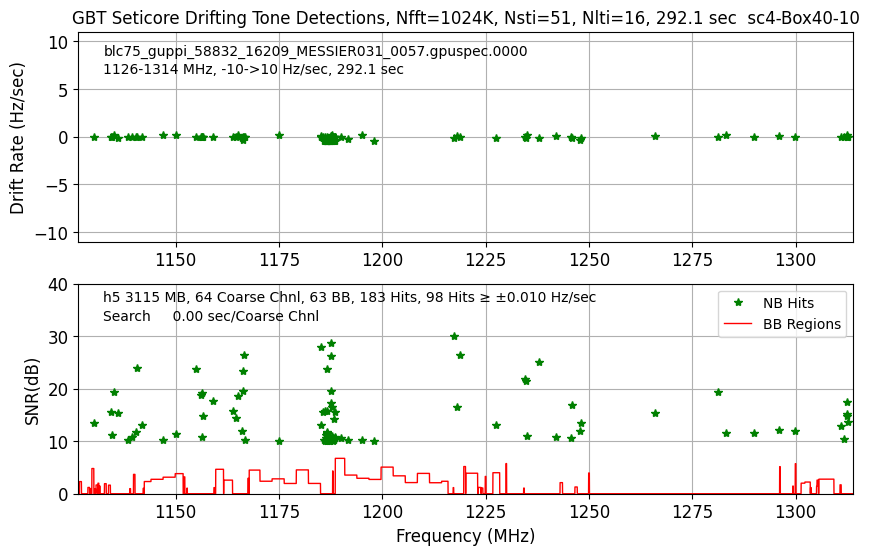

In [28]:
for i_ptype in range(4):

    f1_MHz = f_min_MHz
    f2_MHz = f_max_MHz
    drift1 = search_min_drift-1
    drift2 = search_max_drift+1
    line_width1 = 1
    line_width2 = 1
    x_limits=[f1_MHz,f2_MHz]
    x_label = 'Frequency (MHz)'
    if (i_ptype==0):
        continue    # skip for now
        fig_id = '06-'
        x_data1=[NB_det['f_center_MHz']]
        y_data1=[NB_det['drift_rate']]
        xy_markers1 = ['g*']
        xy_legend1 = []
        x_data2=[NB_det['f_center_MHz']]
        y_data2=[NB_det['snr_db']]
        xy_markers2 = ['g*']
        xy_legend2 = []
    elif (i_ptype==1):
        fig_id = '07-'
        x_data1=[NB_det['f_center_MHz']]
        y_data1=[NB_det['drift_rate']]
        xy_markers1 = ['g*']
        xy_legend1 = []
        x_data2=[NB_det['f_center_MHz'],f_dash]
        y_data2=[NB_det['snr_db'],BB_dash*.15]
        xy_markers2 = ['g*','r-']
        xy_legend2 = ['NB Hits','BB Regions']
    elif (i_ptype==2):
        continue    # skip for now
        fig_id = '08-'
        x_data1=[NB_det_out['f_center_MHz'],NB_det_in['f_center_MHz']]
        y_data1=[NB_det_out['drift_rate'],NB_det_in['drift_rate']]
        xy_markers1 = ['g*','r*']
        xy_legend1 = [f'Hits Outside BB ({n_NB_det_out})',f'Hits Inside BB ({n_NB_det_in})']
        x_data2=[NB_det_out['f_center_MHz'],NB_det_in['f_center_MHz'],f_dash]
        y_data2=[NB_det_out['snr_db'],NB_det_in['snr_db'],BB_dash*.15]
        xy_markers2 = ['g*','r*','r-']
        xy_legend2 = ['Hits Outside BB','Hits Inside BB','BB Regions']
    elif (i_ptype==3):
        if (plot_channel_idx_dets):
            fig_id = '09-'
            x_data1=[NB_det['ChanIndx']]
            y_data1=[NB_det['drift_rate']]
            xy_markers1 = ['g*']
            xy_legend1 = []
            x_data2=[NB_det['ChanIndx']]
            y_data2=[NB_det['snr_db']]
            xy_markers2 = ['g*']
            xy_legend2 = ['NB Hits']    
            x_limits=[0.,p['fine_fft_size']]
            x_label = f"Coarse Channel Index, chan_bw={p['chan_bw']*1e-6:.3f} MHz"
        else:
            continue    # skip for now
    
    %matplotlib inline
    fig = plt.figure(figsize=(10, 6))

    plt.subplot(2,1,1)

    fig_text_list1=[[.15,.84,input_file_stem],
            [.15,.81,f'{f_min_MHz:.0f}-{f_max_MHz:.0f} MHz, {search_min_drift:.0f}->{search_max_drift:.0f} Hz/sec, {t_obs:.1f} sec']]
    
    pltg.plot_generic(fig=fig,x_data=x_data1,y_data=y_data1,xy_markers=xy_markers1,line_width=line_width1,xy_legend=xy_legend1,
                x_limits=x_limits,
                y_limits=[drift1,drift2],
                x_label = [],
                y_label = 'Drift Rate (Hz/sec)',
                fig_title= telescope.upper() + ' '+search_app_string+' Drifting Tone Detections, ' + config_str,
                fig_text_list=fig_text_list1)
            
    plt.subplot(2,1,2)

    fig_text_list2=[[.15,.43,f'h5 {h5_size_MB:3.0f} MB, {n_coarse_channels} Coarse Chnl, {n_BB_det} BB, {n_NB_det0} Hits, '+
                    f'{n_NB_det} Hits \u2265 ±{min_abs_drift_Hz_sec:5.3f} Hz/sec'],
                    [.15,.40,f'Search    {t_search:5.2f} sec/Coarse Chnl']]

    pltg.plot_generic(fig=fig,x_data=x_data2,y_data=y_data2,xy_markers=xy_markers2,line_width=line_width2,xy_legend=xy_legend2,
                x_limits=x_limits,
                y_limits=[0., 40.],
                x_label = x_label,
                y_label = 'SNR(dB)',
                fig_title= '',
                fig_text_list=fig_text_list2,
                legend_loc = 'upper right')

    plt.savefig(fig_dir + fig_id + fig_name_base+'-det-'+test_case+'.png',bbox_inches='tight')

    if display_figs01:
        plt.show()
    else:
        plt.close(fig)


In [29]:
t_e2e = time.time() - t_e2e_start
print(f'seti_h5_find_hits completed, {t_e2e:.2f} sec\n')

seti_h5_find_hits completed, 162.84 sec



In [30]:
if beep_when_h5_complete:
    try:
        # Beep in WSL
        if os.system("powershell.exe '[console]::beep(261.6,700)'") !=0:
            raise Exception('powershell.exe not found')
    except:
        # linux, probably doesn't work
        print('Beep!')
        os.system("echo -ne '\a'")